In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import shutil
import numpy as np
import pathlib

In [2]:
bucket_destination_dir = pathlib.Path("./train_buckets") 

training_folder = bucket_destination_dir

BATCH_SIZE = 32
IMG_SIZE = (128, 128)

train_images = None
validation_images = None

def get_train_data():
    train_images = tf.keras.preprocessing.image.ImageDataGenerator(
                                horizontal_flip=True,
                                vertical_flip=True,
                                rescale=1. / 255,
                                validation_split=0.2,
                                zoom_range=0.1,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                rotation_range=30,
                               ).flow_from_directory(directory=training_folder,
                                                     target_size=(128, 128),
                                                     subset='training',
                                                    )
    
    return train_images

def get_validation_data():
    validation_images = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1 / 255,
                                validation_split=0.2,
                               ).flow_from_directory(directory=training_folder,
                                                     target_size=(128, 128),
                                                     subset='validation',
                                                    ),
    return validation_images

In [4]:
tf.keras.backend.set_image_data_format('channels_last')

mobilenet_model = tf.keras.applications.mobilenet.MobileNet(input_shape=(128 , 128, 3),
                                           include_top=False,
                                           weights='imagenet')

mobilenet_model.trainable = False

# Adding some more layers at the end of the Model as per our requirement
model = tf.keras.models.Sequential([
    mobilenet_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation="relu"),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(5, activation='softmax') # 5 Output Neurons for 5 Classes
])

In [5]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

In [6]:
# Viewing the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 5)                 2

In [7]:
!pip install pydot

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p38/bin/python -m pip install --upgrade pip' command.


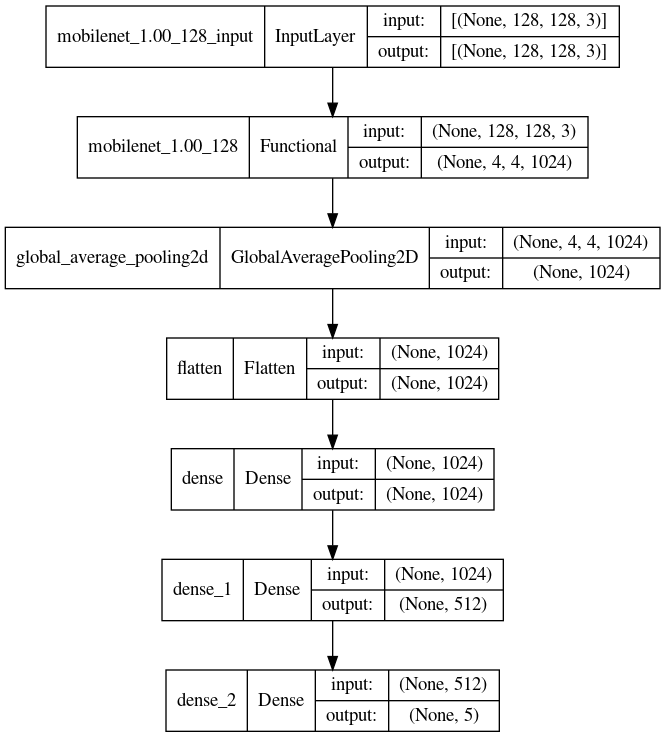

In [8]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [9]:
history = model.fit(get_train_data(), validation_data=get_validation_data(), epochs=5)

Found 39449 images belonging to 5 classes.
Found 9859 images belonging to 5 classes.
Epoch 1/5
1233/1233 [==============================] - 578s 468ms/step - loss: 1.3282 - accuracy: 0.4046 - val_loss: 1.2958 - val_accuracy: 0.4240
Epoch 2/5
1233/1233 [==============================] - 572s 464ms/step - loss: 1.2812 - accuracy: 0.4301 - val_loss: 1.3048 - val_accuracy: 0.4280
Epoch 3/5
1233/1233 [==============================] - 571s 461ms/step - loss: 1.2610 - accuracy: 0.4410 - val_loss: 1.2693 - val_accuracy: 0.4384
Epoch 4/5
1233/1233 [==============================] - 568s 461ms/step - loss: 1.2483 - accuracy: 0.4459 - val_loss: 1.2777 - val_accuracy: 0.4412
Epoch 5/5
1233/1233 [==============================] - 568s 461ms/step - loss: 1.2410 - accuracy: 0.4505 - val_loss: 1.2511 - val_accuracy: 0.4513


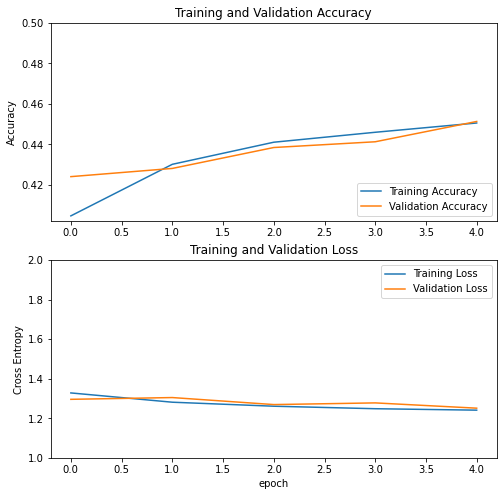

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),0.5])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([1,2])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()